In [548]:
#Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,train_test_split,learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

import pickle

Read the CSV file

In [549]:
#Load the data
df=pd.read_csv('heart.csv')


In [550]:
#data head
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [551]:
#data tail
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [552]:
#data dimensions
df.shape

(303, 14)

In [553]:
#data info
df.info()
#Observed that there is no any missing values or null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Data preprocessing

In [554]:
#checking for missing values
df.isnull().sum()
# just rechecking with another way
#No any missing values


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [555]:
#checking for duplicates
df.duplicated().sum()


1

In [556]:
#removing duplicates
df.drop_duplicates(inplace = True)
#and update the same df

In [557]:
#checking the boundraies of the data that are bounded with specific range 
df = df[(df['thal'] <= 3) & (df['thal'] >= 1)]
df = df[(df['ca'] >= 0) & (df['ca'] <= 3)]
df = df[(df['restecg'] <= 2) & (df['restecg'] >= 0)]
df = df[(df['cp'] <= 3) & (df['cp'] >= 0)]

#and here 6 rows were removed
df.count()

age         296
sex         296
cp          296
trestbps    296
chol        296
fbs         296
restecg     296
thalach     296
exang       296
oldpeak     296
slope       296
ca          296
thal        296
target      296
dtype: int64

In [558]:
#Data columns
col=df.columns
col

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

Exploratry Data Analysis Visualizing my data and understanding the correlations and the data destribution

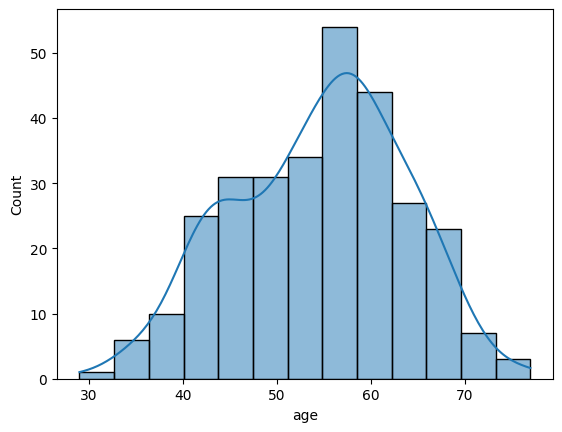

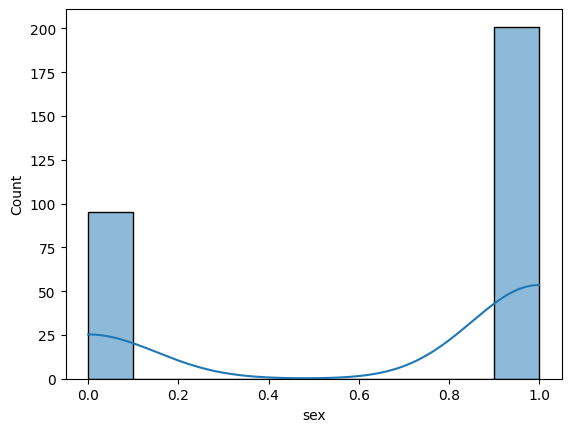

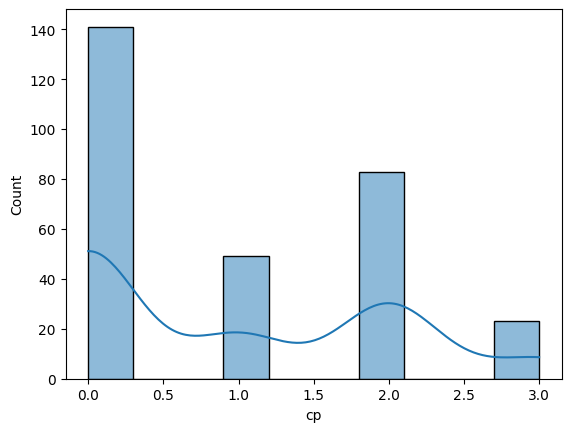

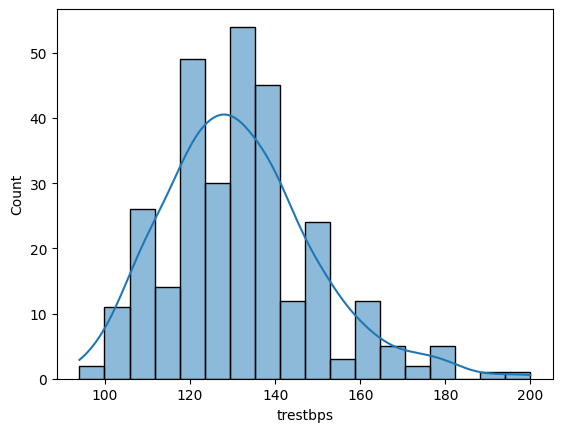

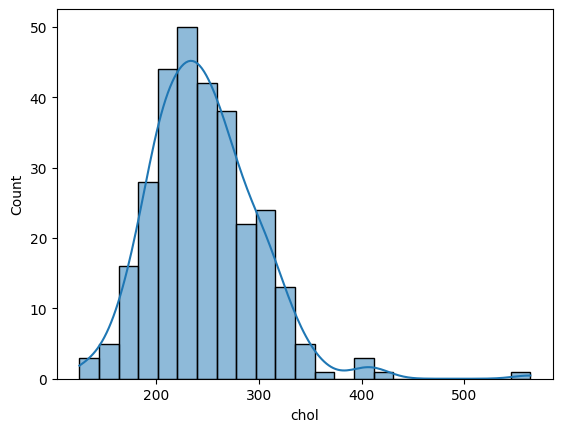

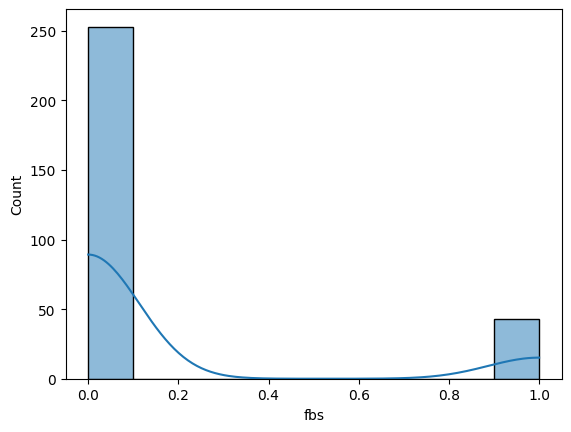

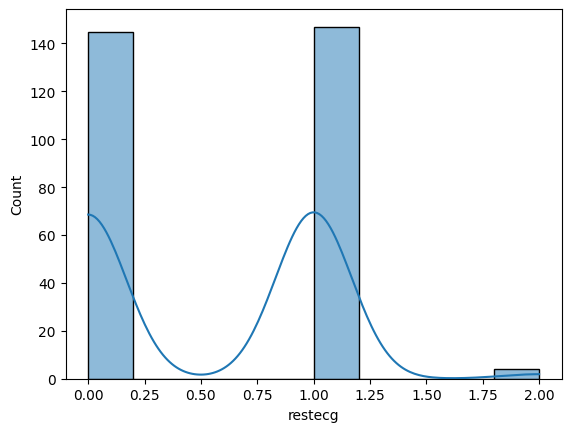

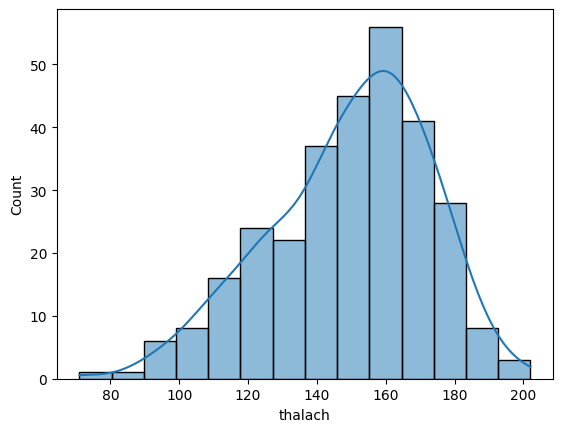

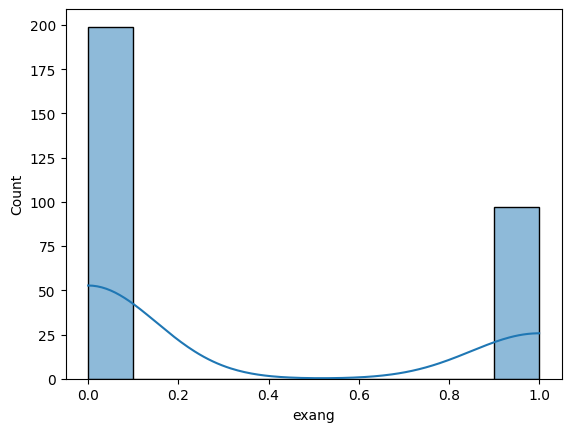

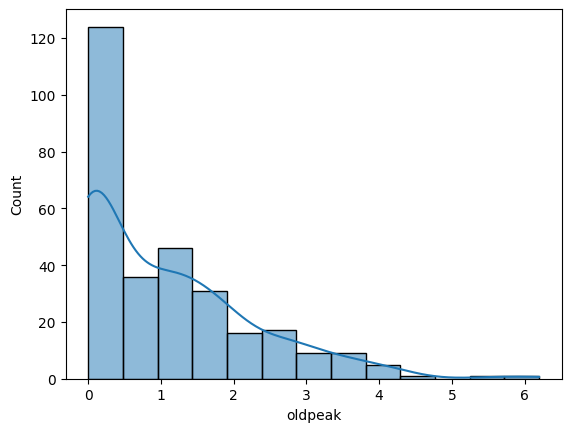

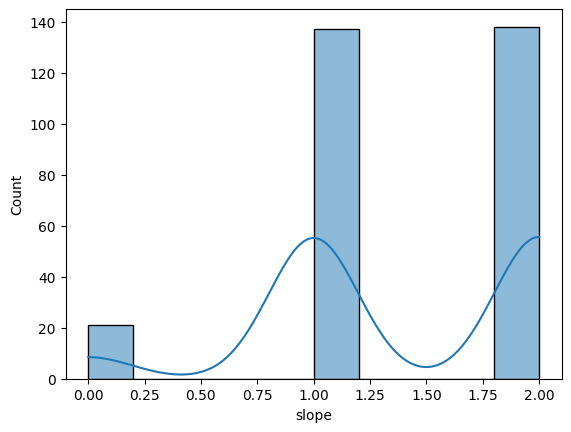

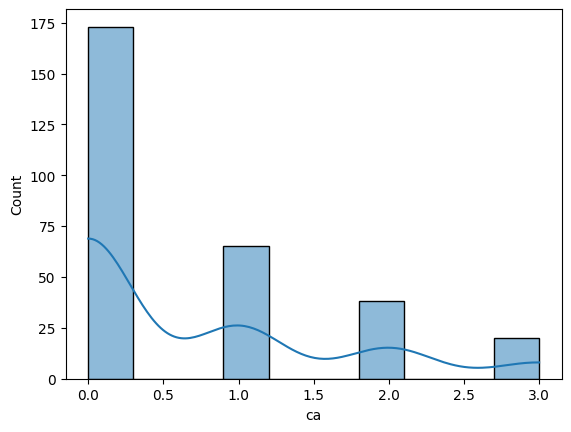

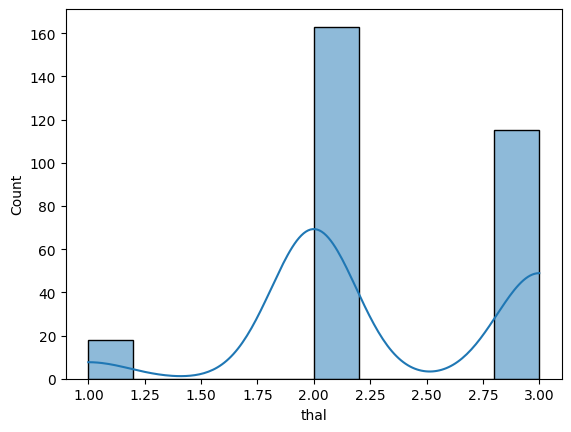

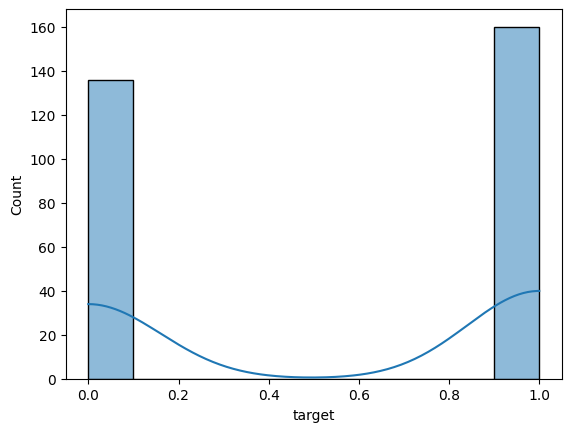

In [559]:
#Understanding the distribution through histograms
for i in col:
    sns.histplot(data = df,x=i,kde=True)
    plt.show()
#observed that age,trestbps,chol,thalach,oldpeak are normally distributed but there is a skewness in some of them

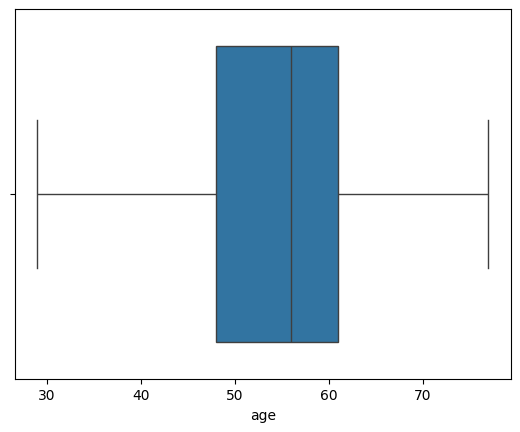

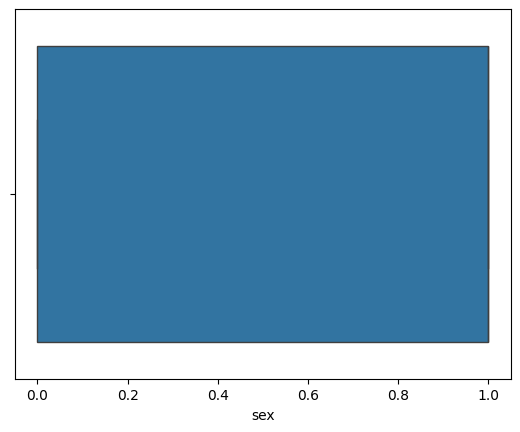

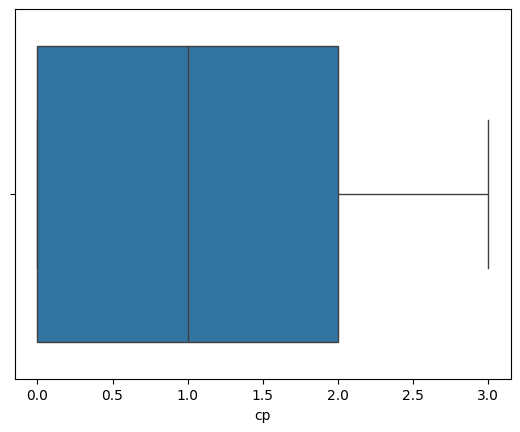

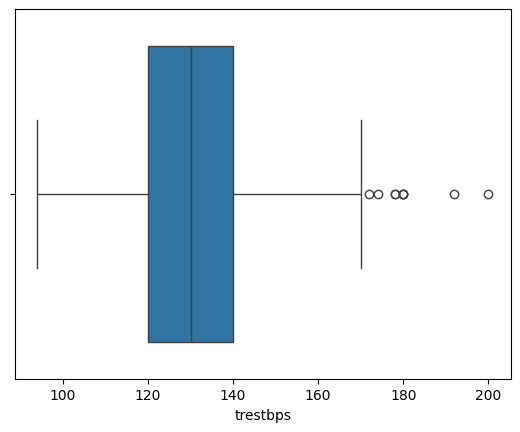

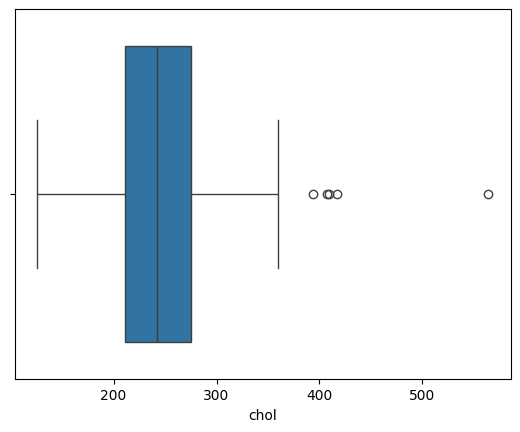

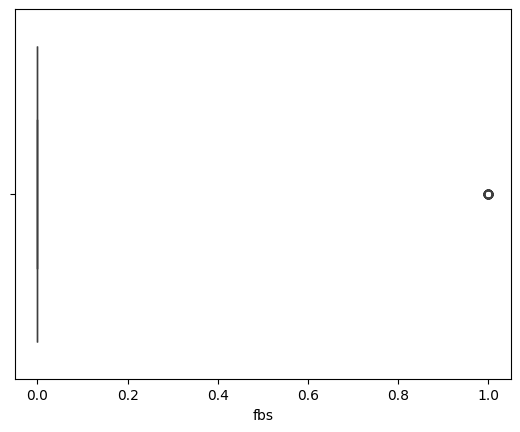

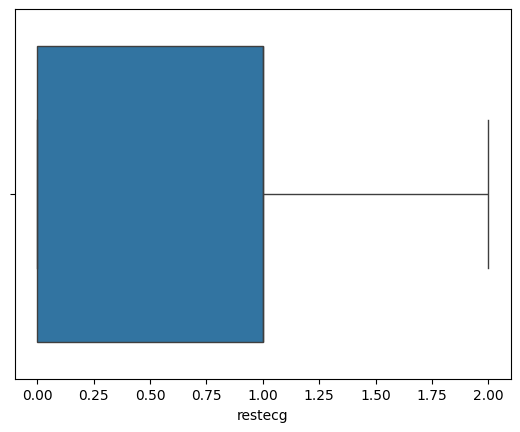

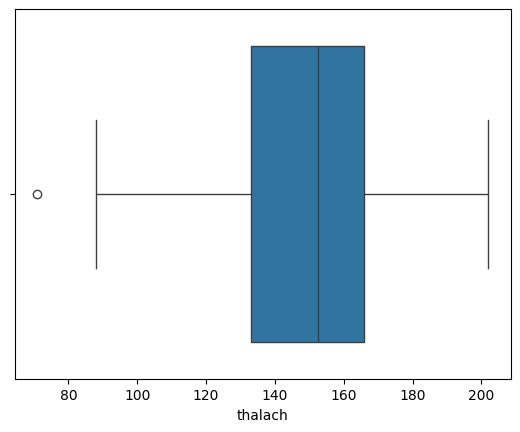

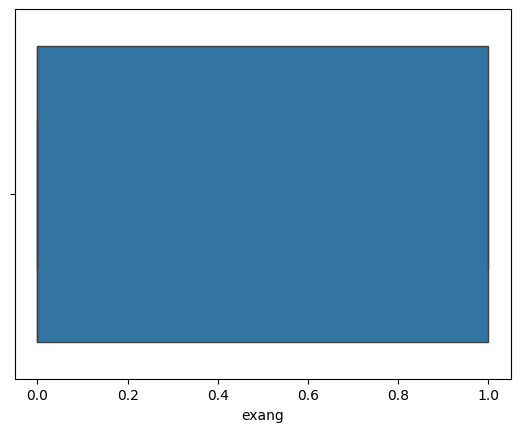

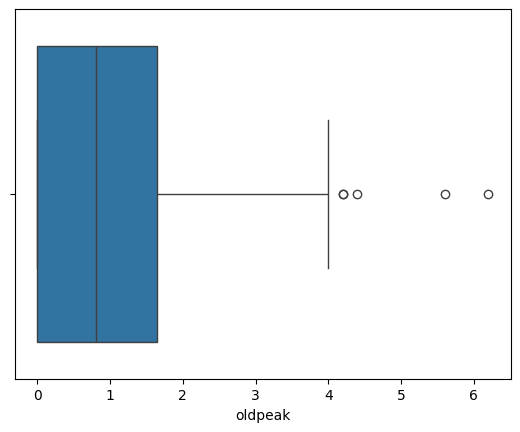

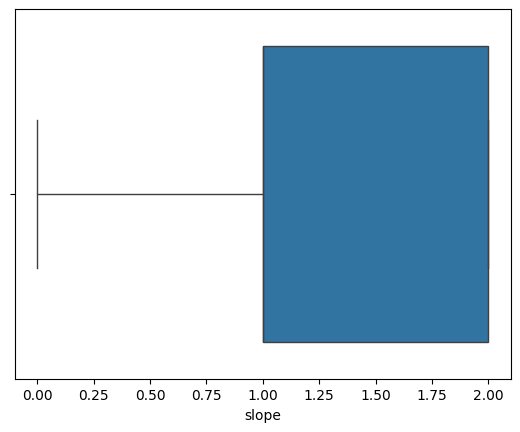

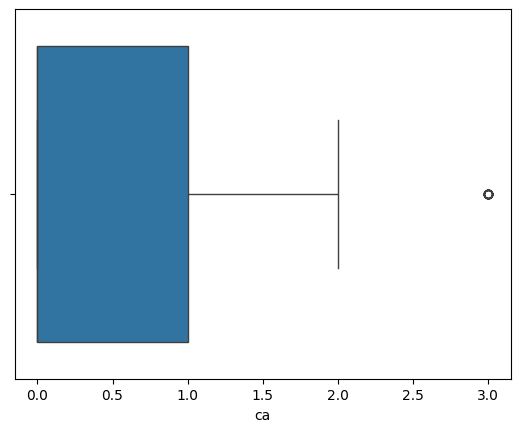

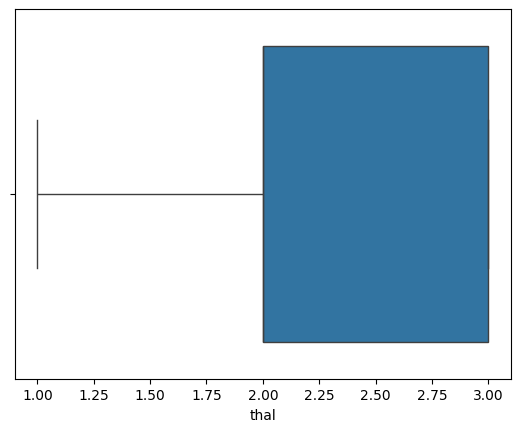

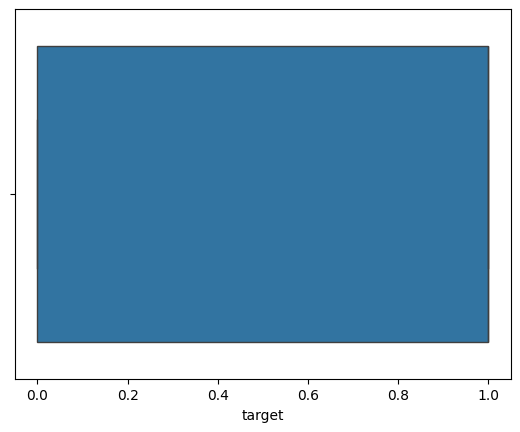

In [560]:
#Understanding the outliers through boxplot
for i in col:
    sns.boxplot(data = df,x=i)
    plt.show()
#There are outliers in trestbps,chol,fbs and observed that the dominant value in fbs is 0 also there are outliers in ca and oldpeak



In [561]:
#proving what observed from the graph
df['fbs'].value_counts()

fbs
0    253
1     43
Name: count, dtype: int64

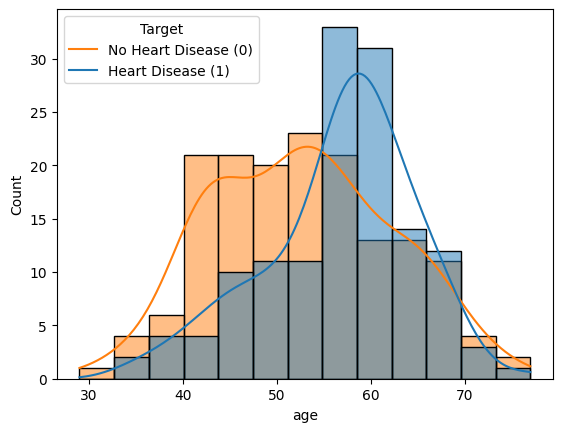

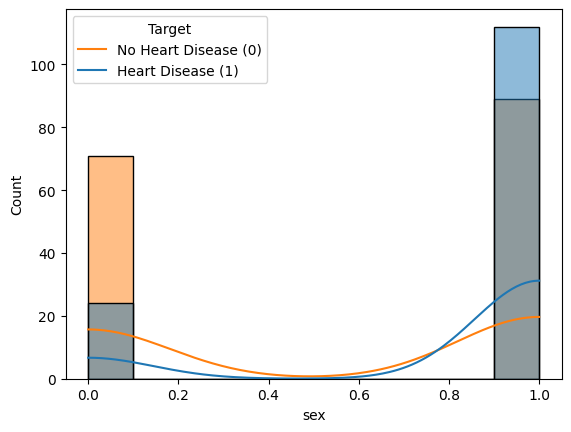

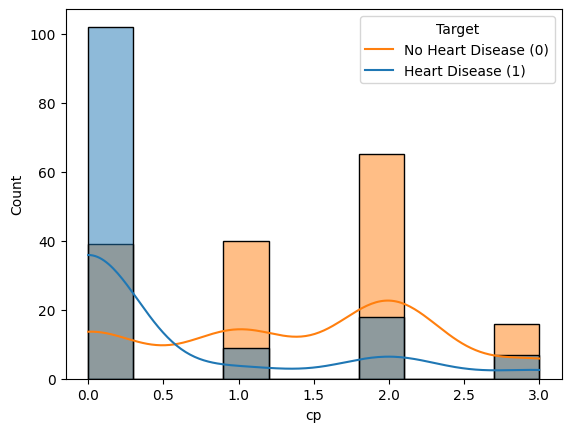

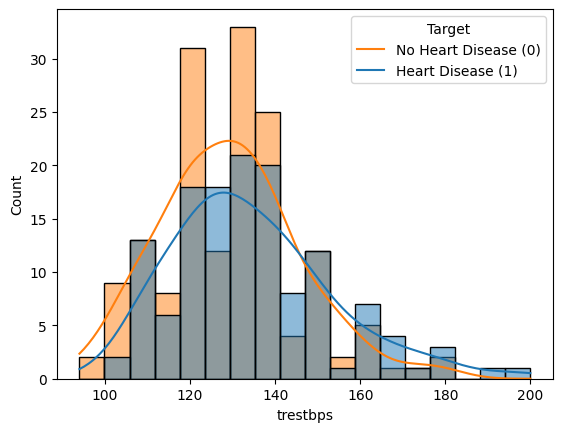

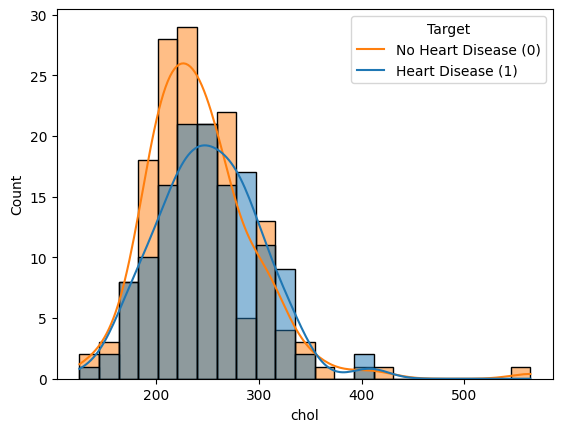

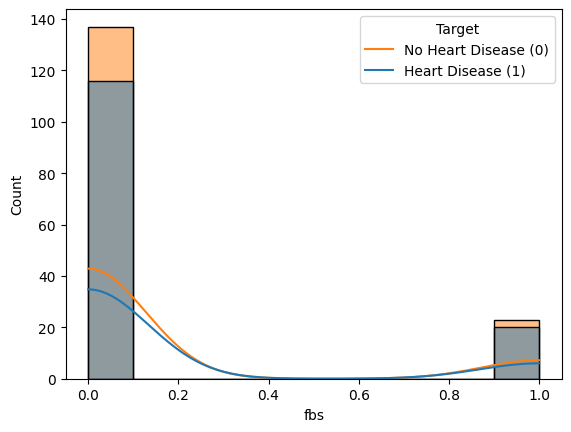

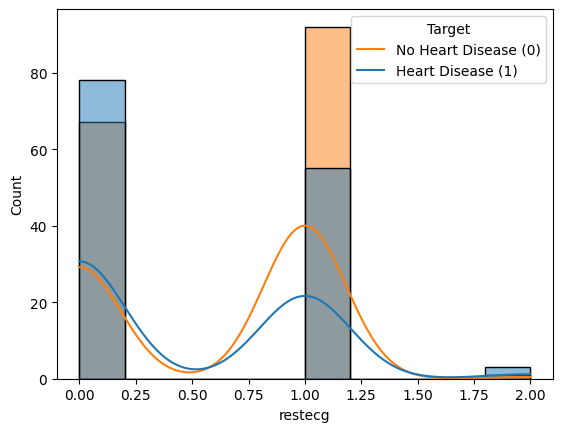

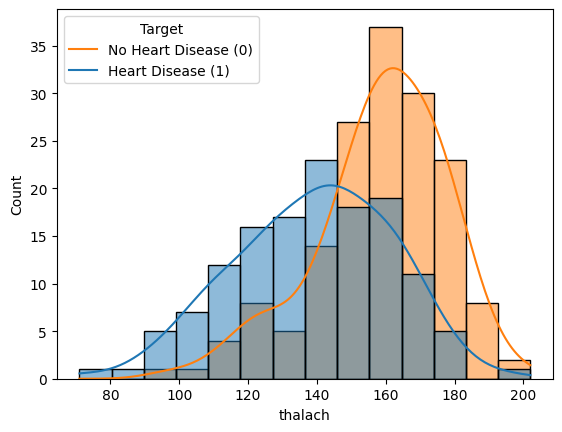

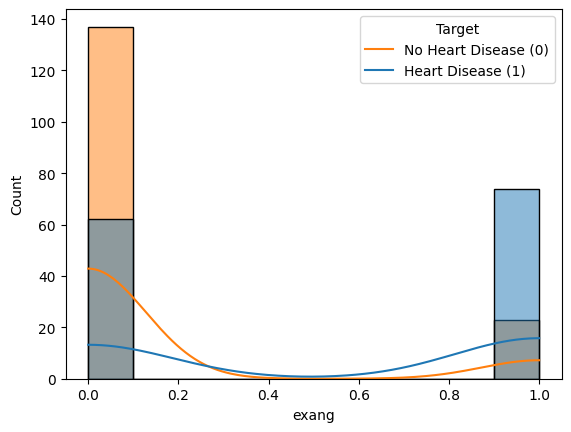

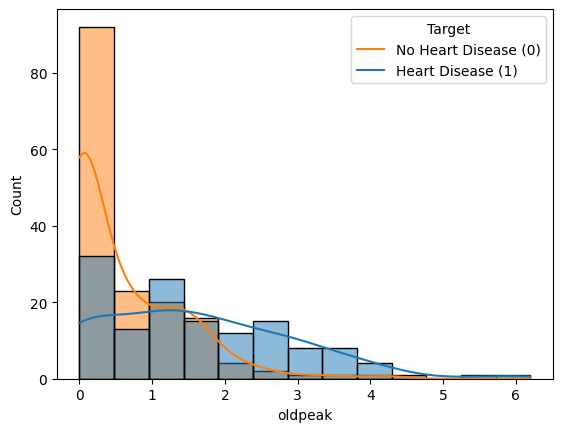

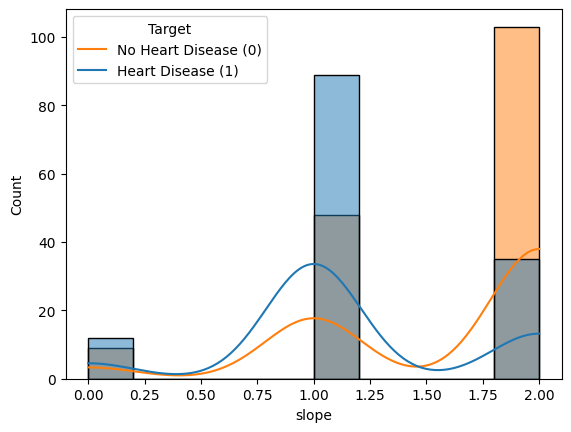

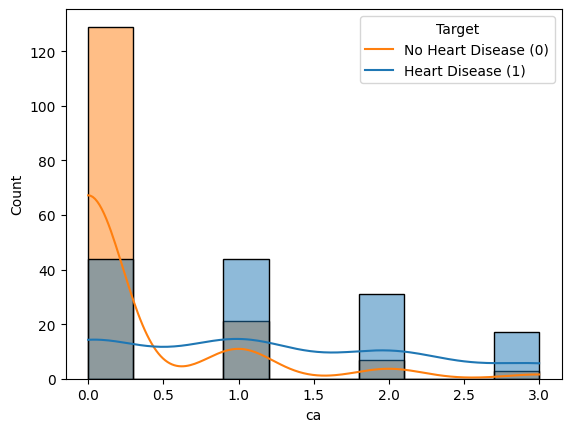

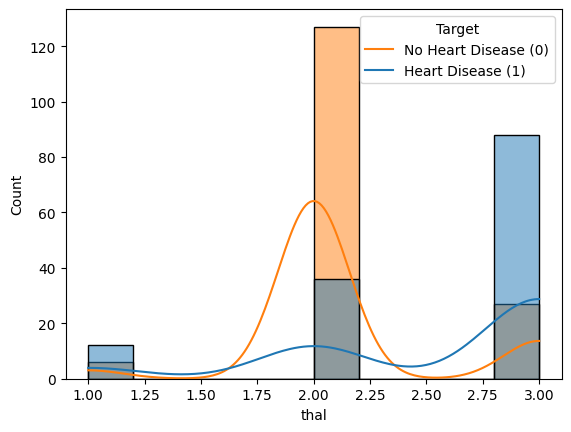

In [562]:
# Relation Between the Target and each attribute
for i in ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
            'exang', 'oldpeak', 'slope', 'ca', 'thal']:
    sns.histplot(data=df, x=i, hue='target', kde=True, )
    plt.legend(title='Target', labels=['No Heart Disease (0)', 'Heart Disease (1)'])
    plt.show()

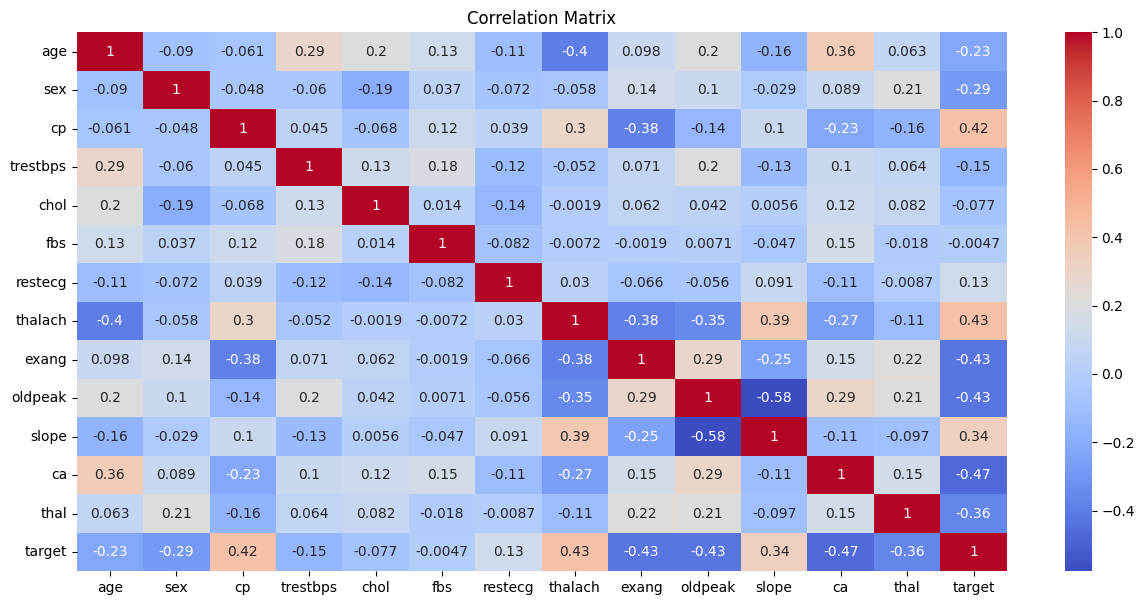

In [563]:
# Correlation Matrix to see the correlation between features and target and also to see between each feature and the others
corr_matrix = df.corr()
plt.figure(figsize=(15, 7))
sns.heatmap(corr_matrix, annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Fixing the Outliers by Setting the outliers with the upper or the lower bound

In [564]:
#Getting the upper bound and the lower bound of the whisker
def whisker(col):
    q1=np.percentile(df[col],25)
    q3=np.percentile(df[col],75)
    iqr=q3-q1
    lower=q1-1.5*iqr
    upper=q3+1.5*iqr
    return lower,upper

In [565]:
#Fixing Outliers for these Columns
for i in ['trestbps', 'chol', 'thalach', 'oldpeak']:
    lower,upper=whisker(i)
    df[i]=np.where(df[i]>upper,upper,df[i])
    df[i]=np.where(df[i]<lower,lower,df[i])
#Applying the outliers in each column either with the upper bound or the lower bound upon its value and update the same df

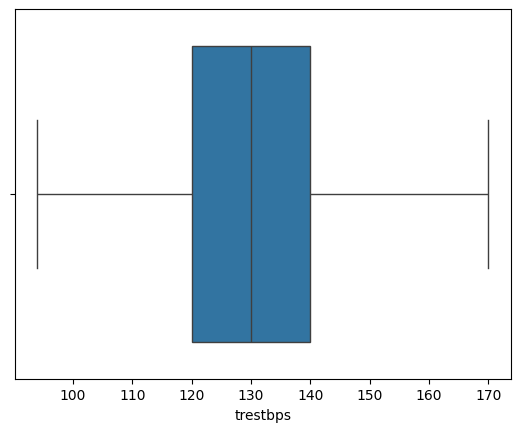

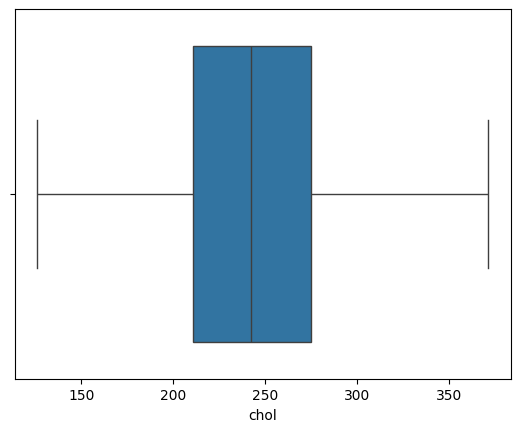

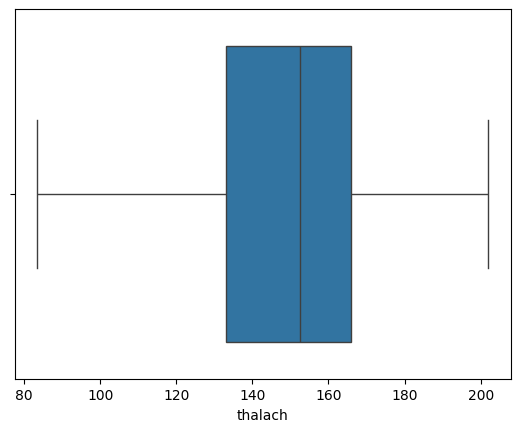

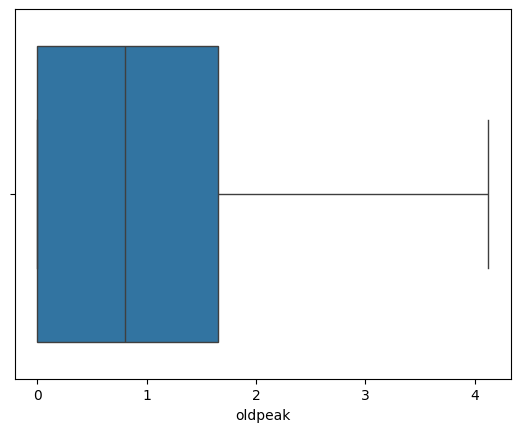

In [566]:
#Checking for Outliers
for i in ['trestbps', 'chol', 'thalach', 'oldpeak']:
    sns.boxplot(data = df,x=i)
    plt.show()

In [567]:
df.describe(include='all')
#the male are the dominant in the dataset as the mean is 0.68 also the target is balanced as the mean is 0.54 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,0.679054,0.959459,131.253378,246.030828,0.14527,0.523649,149.603041,0.327703,1.045693,1.395270,0.679054,2.327703,0.540541
std,9.059471,0.467631,1.034184,16.757897,47.710956,0.35297,0.526692,22.836976,0.470171,1.120533,0.618235,0.939726,0.585743,0.499198
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.00000,0.000000,83.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.00000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,242.500000,0.00000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.250000,0.00000,1.000000,166.000000,1.000000,1.650000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,170.000000,371.625000,1.00000,2.000000,202.000000,1.000000,4.125000,2.000000,3.000000,3.000000,1.000000


Splitting my data to training and testing data

In [568]:
# Spliting the data to 80% training and 20% testing and we shuffle it as our data sorted by target (target=1 then target=0)
X = df.drop(["target"], axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
X_test.shape, X_train.shape, y_test.shape, y_train.shape


((60, 13), (236, 13), (60,), (236,))

Normalizing the attributes that have a wide range than user attributes like (age,chol,trestbps,thalach,oldpeak)

In [569]:
#Normailze Age,Oldpeak as they are not gaussian distribution using minmax scaler

minmax_scaler = MinMaxScaler()
X_train[['age', 'oldpeak']] = minmax_scaler.fit_transform(X_train[['age', 'oldpeak']])
X_test[['age', 'oldpeak']] = minmax_scaler.transform(X_test[['age', 'oldpeak']])


In [570]:
#Normalize trestbps, chol, thalach as they are gaussian distribution using standard scaler
standard_scaler = StandardScaler()
X_train[['thalach', 'trestbps', 'chol']] = standard_scaler.fit_transform(X_train[['thalach', 'trestbps', 'chol']])
X_test[['thalach', 'trestbps', 'chol']] = standard_scaler.transform(X_test[['thalach', 'trestbps', 'chol']])


Running the 2 models without any hyperparamters or any feature selections

we choosed the both the Logistic Regression and the Random Forest as our target is not a continous number it is just eithe 1 or 0 and the LR can learn fast on this dataset

In [571]:
# Train Logistic Regression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_log_reg))
print('F1 Score: ',f1_score(y_test, y_pred_log_reg))

Logistic Regression Accuracy: 0.8833333333333333
F1 Score:  0.8888888888888888


In [572]:
# Train Random Forest
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print('F1 Score: ',f1_score(y_test, y_pred_rf))


Random Forest Accuracy: 0.8833333333333333
F1 Score:  0.8888888888888888


Feature Selection Process using the Varience threshold and dropping attributes that are less than 0.2

In [573]:
#Feature selection using Variance Threshold

X_train.var(axis=0)

#set the threshold to 0.2
# so will try running the model again after dropping (fbs,oldpeak,age)

age         0.035333
sex         0.219257
cp          1.110188
trestbps    1.004255
chol        1.004255
fbs         0.126848
restecg     0.276145
thalach     1.004255
exang       0.214551
oldpeak     0.070989
slope       0.378507
ca          0.871475
thal        0.336873
dtype: float64

In [574]:
# After dropping the colums with variance less than 0.2 also we can use RFE but acctualy 
# I noticed it too late so I don't have time to apply it but 
# I think that it will be much efficent and effective than the variance threshold

X_train_Selected=X_train.drop(['age','fbs','oldpeak'],axis=1)
X_test_Selected=X_test.drop(['age','fbs','oldpeak'],axis=1)
X_test_Selected.columns
#using 10 attributes rather than 13 so it is much better 


Index(['sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'slope',
       'ca', 'thal'],
      dtype='object')

Running the Models After the Feature Selection process

In [575]:

log_reg.fit(X_train_Selected, y_train)
y_pred_log_reg_with_feature_selection = log_reg.predict(X_test_Selected)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_log_reg_with_feature_selection))    
print('F1 Score:', f1_score(y_test, y_pred_log_reg_with_feature_selection))


Logistic Regression Accuracy: 0.8833333333333333
F1 Score: 0.8888888888888888


In [576]:
rf.fit(X_train_Selected, y_train)
y_pred_RF_with_feature_selection= rf.predict(X_test_Selected)
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_RF_with_feature_selection))
print('F1 Score:', f1_score(y_test, y_pred_RF_with_feature_selection))


Random Forest Accuracy: 0.8833333333333333
F1 Score: 0.8888888888888888


After Feature Selection and Running the Logistic Regression using C=0.01

In [577]:
Logi_reg = LogisticRegression(C=0.01)
Logi_reg.fit(X_train_Selected, y_train)
y_Logi_reg_pred = Logi_reg.predict(X_test_Selected)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_Logi_reg_pred))    
print('F1 Score:', f1_score(y_test, y_Logi_reg_pred))

Logistic Regression Accuracy: 0.9333333333333333
F1 Score: 0.9375


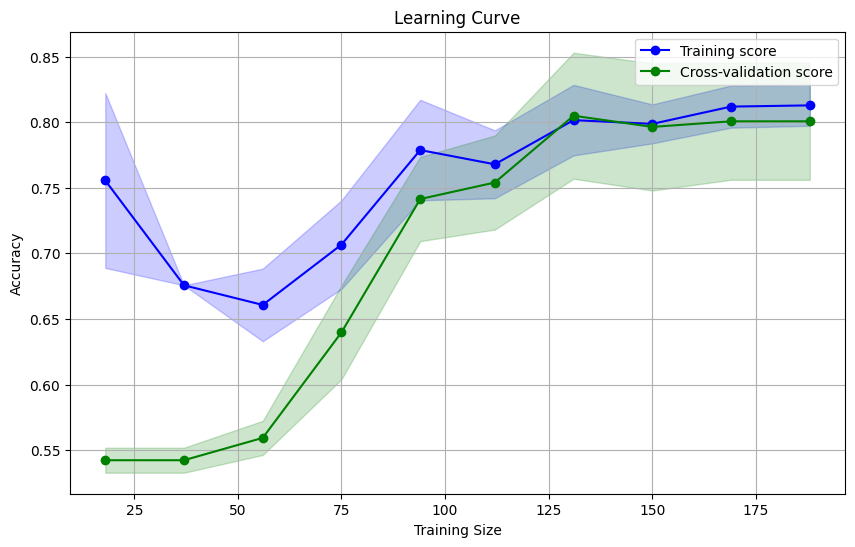

In [578]:

def plot_learning_curve(model, X, y, scoring='accuracy', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green', marker='o')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='green')

    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid()
    plt.show()
#plotting the learning curve for the logistic regression and it is to a certain extend well fitted
plot_learning_curve(LogisticRegression(C=0.01), X_train_Selected, y_train, scoring='accuracy')


Using the GridSearchCV to find the best combinations of hyperParamters to fine tune the Random Forest Model

In [579]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
max_features = [None,'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]+[None]


In [580]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': [3],
               'min_samples_leaf': [4]
               }
param_grid


{'n_estimators': [10, 55, 100],
 'max_features': [None, 'sqrt', 'log2'],
 'max_depth': [10, 60, 110, None],
 'min_samples_split': [3],
 'min_samples_leaf': [4]}

In [581]:
#it tries all the combinations of the parameters and gives the best one
rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5)

In [582]:
rf_Grid.fit(X_train_Selected, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 60, 110, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [4], 'min_samples_split': [3],
                         'n_estimators': [10, 55, 100]})

In [583]:
y_pred_rf_Grid=rf_Grid.predict(X_test_Selected)
rf_Grid.best_params_

{'max_depth': 60,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 10}

In [584]:
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf_Grid))
print('F1 Score:', f1_score(y_test, y_pred_rf_Grid))

Random Forest Accuracy: 0.8666666666666667
F1 Score: 0.8709677419354839


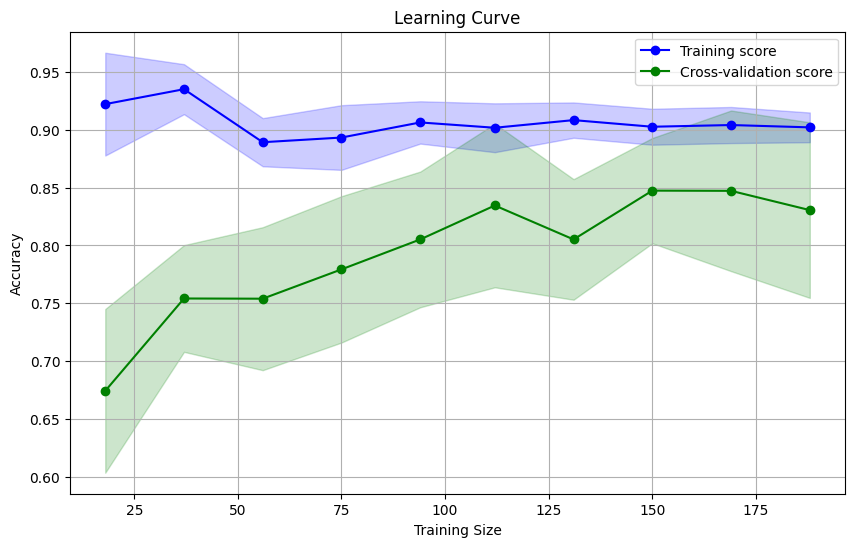

In [585]:
#Here is tis clear that our model is overfitting
plot_learning_curve(rf_Grid, X_train_Selected, y_train, scoring='accuracy')

Evaluating our Model

using the Accuracy,F1-Socre,recall,precision metric as it is not continus data it is either 1 or 0 also as they consider the TN,TP,FP,FN

In [586]:


def eval_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)

    labels = [
        f"TN = {cm[0, 0]}",  
        f"FP = {cm[0, 1]}", 
        f"FN = {cm[1, 0]}",  
        f"TP = {cm[1, 1]}"  
    ]

    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot=labels, fmt='')

    plt.title(f'Confusion Matrix for {model_name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    if(model_name=='Random Forest'):
        plt.savefig(f'static/cm_rf.png')
    else:
        plt.savefig(f'static/cm_log_reg.png')
    plt.show()
    return accuracy, precision, recall, f1

Evaluation Metrics for Random Forest:
Accuracy: 0.8667
Precision: 0.9000
Recall: 0.8438
F1-Score: 0.8710


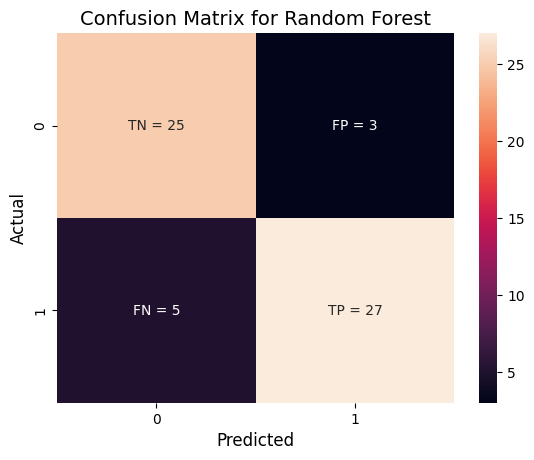

In [587]:
accuracy1,precision1,recall1,f11=eval_model(rf_Grid, X_test_Selected, y_test, model_name="Random Forest")


Evaluation Metrics for Logistic Regression:
Accuracy: 0.9333
Precision: 0.9375
Recall: 0.9375
F1-Score: 0.9375


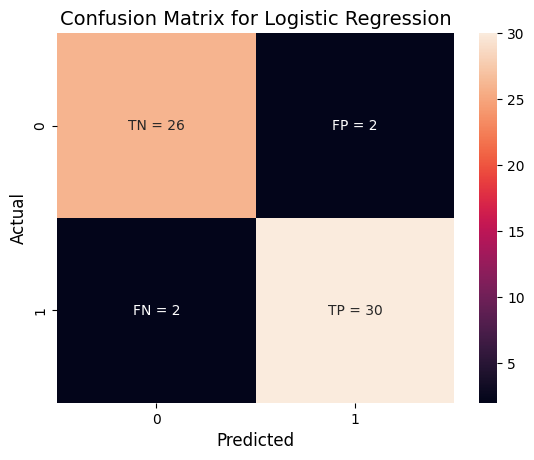

In [588]:
#Logistic Regression evaluation
accuracy,precision2,recall2,f12=eval_model(Logi_reg, X_test_Selected, y_test, model_name="Logistic Regression")


Comparisson between the Models before and after each enhancment

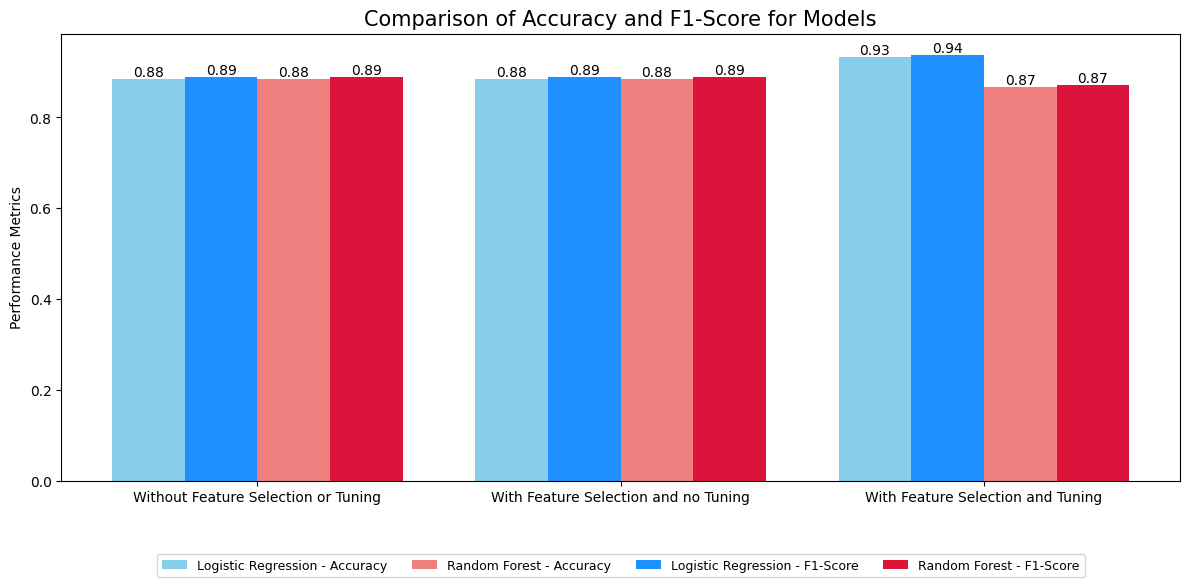

In [ ]:
results = pd.DataFrame({
    # 'Model': ['Logistic Regression', 'Random Forest'],
    'States':['Without Feature Selection or Tuning','With Feature Selection and no Tuning','With Feature Selection and Tuning'],
    'Accuracy of Logistic Regression Model': [accuracy_score(y_test, y_pred_log_reg), accuracy_score(y_test, y_pred_log_reg_with_feature_selection), accuracy_score(y_test, y_Logi_reg_pred)],
    'Accuracy of Random Forest Model': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test,y_pred_RF_with_feature_selection), accuracy_score(y_test, y_pred_rf_Grid)],
    'F1-Score of Logistic Regression Model': [f1_score(y_test, y_pred_log_reg), f1_score(y_test, y_pred_log_reg_with_feature_selection), f1_score(y_test, y_Logi_reg_pred)],
    'F1-Score of Random Forest Model': [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_RF_with_feature_selection), f1_score(y_test, y_pred_rf_Grid)]
})

states = results['States']
log_reg_accuracy = results['Accuracy of Logistic Regression Model']
rf_accuracy = results['Accuracy of Random Forest Model']
log_reg_f1 = results['F1-Score of Logistic Regression Model']
rf_f1 = results['F1-Score of Random Forest Model']

x = np.arange(len(states))  
width = 0.2  

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width * 1.5, log_reg_accuracy, width, label='Logistic Regression - Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, rf_accuracy, width, label='Random Forest - Accuracy', color='lightcoral')

bars3 = ax.bar(x - width/2, log_reg_f1, width, label='Logistic Regression - F1-Score', color='dodgerblue')
bars4 = ax.bar(x + width * 1.5, rf_f1, width, label='Random Forest - F1-Score', color='crimson')

ax.set_ylabel('Performance Metrics', fontsize=10)
ax.set_title('Comparison of Accuracy and F1-Score for Models', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(states, fontsize=10)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=9)

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom')

plt.tight_layout()
plt.savefig('static/accuracy_f1_comparison.png')
plt.show()


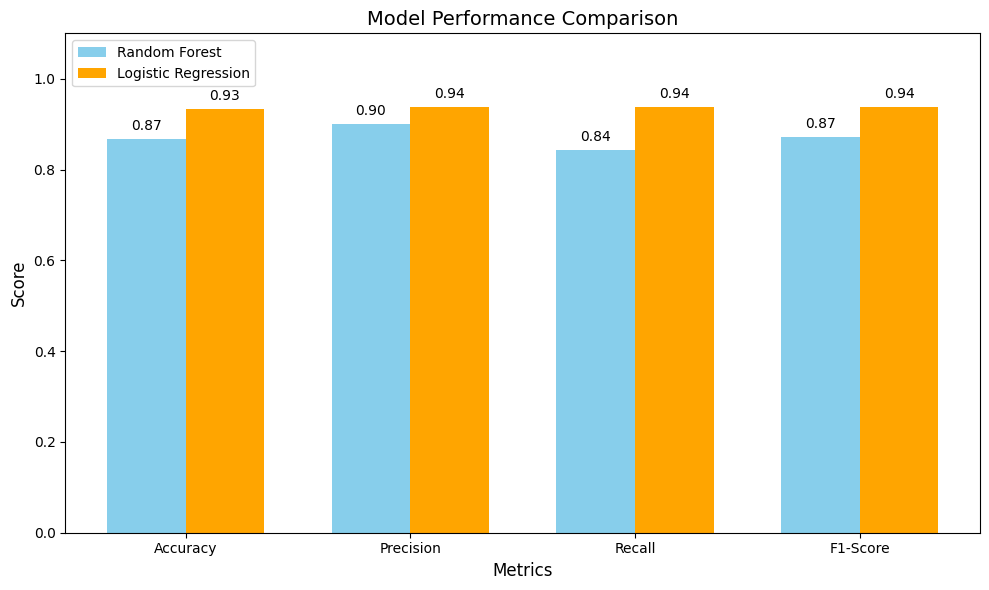

In [590]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
random_forest_scores = [accuracy1, precision1, recall1, f11]
logistic_regression_scores = [accuracy, precision2, recall2, f12]


x = np.arange(len(metrics))
width = 0.35  

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, random_forest_scores, width, label='Random Forest', color='skyblue')
plt.bar(x + width/2, logistic_regression_scores, width, label='Logistic Regression', color='orange')

# Add labels, title, and legend
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.xticks(x, metrics)  # Add metric names as x-ticks
plt.ylim(0, 1.1)  # Set y-axis range to [0, 1.1]
plt.legend(loc='upper left', fontsize=10)

# Annotate bars with their respective scores
for i, v in enumerate(random_forest_scores):
    plt.text(x[i] - width/2, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
for i, v in enumerate(logistic_regression_scores):
    plt.text(x[i] + width/2, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

# Show plot
plt.tight_layout()
plt.savefig('static/model_comparison.png')
plt.show()


Here it is clear that the Logistic Regression model is much better in all metrizies than Random forest Classifier

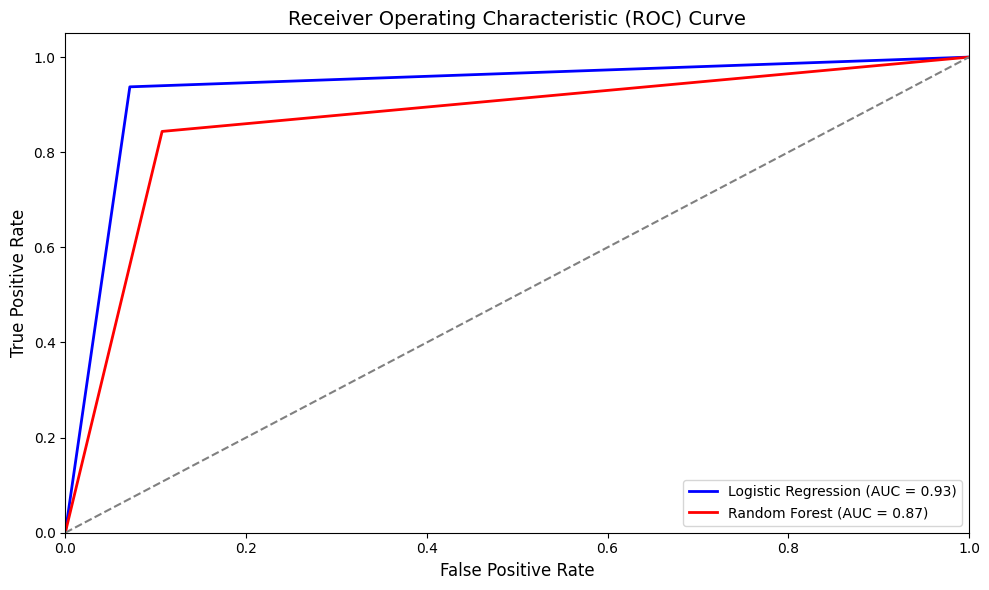

In [ ]:
from sklearn.metrics import auc, roc_curve


def roc_draw():  
    fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_Logi_reg_pred)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_Grid)  
    roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
    plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.tight_layout()
    plt.savefig('static/roc_curve.png')
roc_draw()


Genrating our Pickle file to access the API

In [591]:
with open('LR.pkl', 'wb') as f:
    pickle.dump(Logi_reg, f)